In [80]:
# !pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, date, time
from prophet import Prophet
from numpy import mean, max, maximum, quantile
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [81]:
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [82]:
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
df = transactions.drop(['Value'], axis=1)
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df = df.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

In [83]:
start_date = datetime.combine(date(2021, 10, 16), time(3,0)) 
end_date = datetime.combine(date(2021, 10, 17), time(6,0))

start_date, end_date

(datetime.datetime(2021, 10, 16, 3, 0), datetime.datetime(2021, 10, 17, 6, 0))

In [84]:
# train_df = df[:'2021-10-16 02:59:59']
# test_df = df['2021-10-16 03:00:00':]

In [85]:
def prepare_df(df):
   df = df.reset_index() 
   df = df.rename(columns = {'Date':'ds', 'Price': 'y'}, inplace=False)
   return df

In [86]:
# train_df = prepare_df(train_df)
# test_df = prepare_df(test_df)

df = prepare_df(df)
df

,ds,y
0,2021-01-01 00:00:00,8.084088e+10
1,2021-01-01 00:20:00,8.024579e+10
2,2021-01-01 00:40:00,7.701433e+10
3,2021-01-01 01:00:00,8.713914e+10
4,2021-01-01 01:20:00,7.425917e+10
...,...,...
20947,2021-10-18 22:20:00,1.139328e+11
20948,2021-10-18 22:40:00,9.914658e+10
20949,2021-10-18 23:00:00,8.993732e+10
20950,2021-10-18 23:20:00,7.477979e+10


In [87]:
m = Prophet(changepoint_prior_scale=0.0005,yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, interval_width=0.10)
m.fit(df)

In [88]:
cutoffs = pd.to_datetime(['2021-01-16 03:00:00', '2021-10-16 03:00:00', '2021-10-17 06:00:00'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='27hours')

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


In [89]:
df_p = performance_metrics(df_cv2)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 02:40:00,2.391684e+21,4.890485e+10,4.224171e+10,0.623126,0.518492,0.435400,0.041667
1,0 days 03:00:00,2.405598e+21,4.904690e+10,4.231713e+10,0.635081,0.537581,0.440347,0.041667
2,0 days 03:20:00,2.360269e+21,4.858260e+10,4.204685e+10,0.633694,0.537982,0.440387,0.041667
3,0 days 03:40:00,2.358142e+21,4.856071e+10,4.296423e+10,0.652650,0.537982,0.454558,0.000000
4,0 days 04:00:00,2.228011e+21,4.720182e+10,4.111517e+10,0.622531,0.537982,0.434948,0.000000
...,...,...,...,...,...,...,...,...
69,1 days 01:40:00,3.133510e+21,5.597777e+10,5.160792e+10,0.783198,0.629452,0.533095,0.000000
70,1 days 02:00:00,3.187636e+21,5.645915e+10,5.184498e+10,0.800453,0.629452,0.539398,0.000000
71,1 days 02:20:00,3.191886e+21,5.649678e+10,5.170102e+10,0.809480,0.609455,0.541735,0.000000
72,1 days 02:40:00,3.186826e+21,5.645198e+10,5.154902e+10,0.820602,0.607524,0.544894,0.000000


Text(0.5, 1.0, 'Root Mean Squared Error using Prophet')

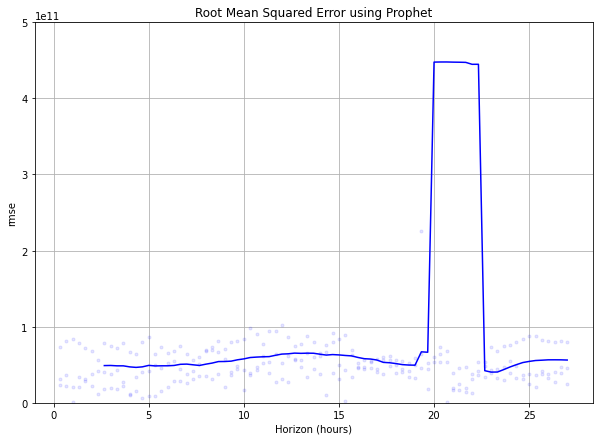

In [90]:
fig = plot_cross_validation_metric(df_cv2, metric='rmse', figsize=(10, 7))
ax = fig.gca()
ax.set_ylim(0, 0.5e12)
ax.set_title('Root Mean Squared Error using Prophet')


In [95]:
def plot1(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6)
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], linestyle='solid', linewidth=3, c='#0072B2')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

Text(0.5, 1.0, 'Predicted versus actual using Prophet 10% pred. interval')

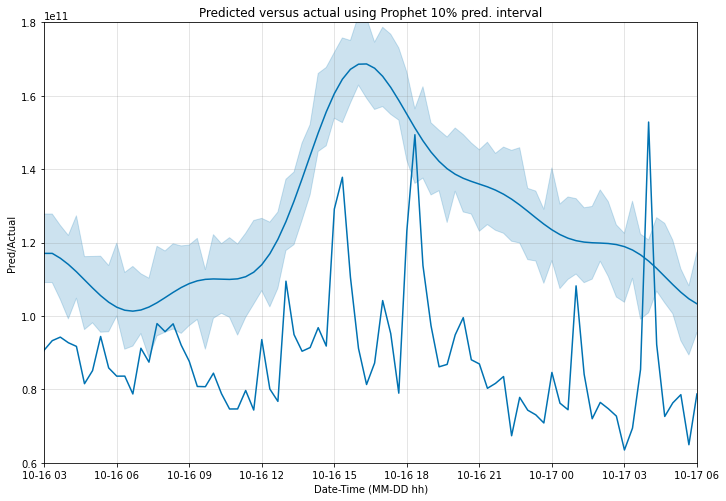

In [96]:
fig1 = plot1(m, df_cv2, figsize=(10, 7), xlabel='Date-Time (MM-DD hh)', ylabel='Pred/Actual')
ax = fig1.gca()
ax.set_xlim([start_date, end_date])
ax.set_ylim(0.6e11, 1.8e11)
ax.set_title('Predicted versus actual using Prophet 10% pred. interval')